In [1]:
hyperparameters = {
    "learning_rate": 1e-4,
    "batch_size": 256,
    "embed_dim": 256,
    "num_heads": 4,
    "num_layers": 4,
    "dropout": 0.2,
    "ff_dim": 1024,
    "epochs": 300,
    "num_warmup_steps": 500,
    "weight_decay": 1e-4,
    "num_extra_features": 6 + 12 + 12,
    "k-mers": 3,
    "max_len": 199
}

info = {
    "dataset_size": "100K",
    "precision": "FP16",
    "dir_name": "Mutation Model",
    "run": "23rd Run",
    "loss": {
        "type": "CB Weighted Cross Entropy Loss",
        "alpha": 0.75, # Removed
        "gamma": 2
    },
    "optimizer": "Adam",
    "is_pre_training": False
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

data_path = f"/content/drive/MyDrive/dataset/{info['dataset_size']}.csv"

data = pd.read_csv(data_path)
data.shape

(100000, 10)

In [4]:
def gc_content(seq):
    seq = seq.upper()
    gc = seq.count('G') + seq.count('C')
    return gc / len(seq)

data['gc_content'] = data['sequence'].apply(gc_content)

In [5]:
def at_content(seq):
    seq = seq.upper()
    return (seq.count('A') + seq.count('T')) / len(seq)

data['at_content'] = data['sequence'].apply(at_content)

In [6]:
def is_cpg_site(row):
    seq = row['sequence'].upper()
    pos = row['mutation_pos']

    if pos < len(seq)-1 and seq[pos] == 'C' and seq[pos+1] == 'G':
        return 1

    if pos > 0 and seq[pos-1] == 'C' and seq[pos] == 'G':
        return 1
    return 0

data['cpg_flag'] = data.apply(is_cpg_site, axis=1)

In [7]:
from collections import Counter
import numpy as np

def sequence_entropy(seq):
    counts = Counter(seq)
    total = len(seq)
    probs = [count / total for count in counts.values()]
    return -sum(p * np.log2(p) for p in probs)

data['sequence_entropy'] = data['sequence'].apply(sequence_entropy)

In [8]:
def is_transition(ref, alt):
    transitions = {('A','G'), ('G','A'), ('C','T'), ('T','C')}
    return 1 if (ref, alt) in transitions else 0

In [9]:
transition = []

for ref, alt in zip(data['ref'].tolist(), data['alt'].tolist()):
    transition.append(is_transition(ref, alt))

data['transition'] = transition

In [10]:
# Human genome chromosome lengths (GRCh38)
chrom_lengths = {
    'chr1': 248956422,
    'chr2': 242193529,
    'chr3': 198295559,
    'chr4': 190214555,
    'chr5': 181538259,
    'chr6': 170805979,
    'chr7': 159345973,
    'chr8': 145138636,
    'chr9': 138394717,
    'chr10': 133797422,
    'chr11': 135086622,
    'chr12': 133275309,
    'chr13': 114364328,
    'chr14': 107043718,
    'chr15': 101991189,
    'chr16': 90338345,
    'chr17': 83257441,
    'chr18': 80373285,
    'chr19': 58617616,
    'chr20': 64444167,
    'chr21': 46709983,
    'chr22': 50818468,
}

# Function to normalize genomic position
def normalized_genomic_pos(row):
    chrom = row['chrom']
    chrom_length = chrom_lengths.get(chrom, 1)  # Default 1 to avoid division by zero
    return row['genomic_pos'] / chrom_length

# Apply normalization
data['genomic_pos_norm'] = data.apply(normalized_genomic_pos, axis=1)

In [11]:
data = pd.get_dummies(data, columns=['mutation_type'])

In [12]:
data = pd.get_dummies(data, columns=['chrom'])

In [13]:
data.head()

,sequence,label,mutation_pos,ref,alt,genomic_pos,context_left,context_right,gc_content,at_content,...,chrom_chr11,chrom_chr12,chrom_chr2,chrom_chr3,chrom_chr4,chrom_chr5,chrom_chr6,chrom_chr7,chrom_chr8,chrom_chr9
0,CCGGTTGTTGCACCATGGCGTCCATGGGGACCCTCGCCTTCGATGA...,2,101,G,A,10250427,CCGGTTGTTGCACCATGGCGTCCATGGGGACCCTCGCCTTCGATGA...,GGACTTGAGGCCCTCAAGGTAATGGCACAGGGACCTGCTCGCGGTG...,0.626866,0.373134,...,False,False,False,False,False,True,False,False,False,False
1,GAAGAGGCGGCATTAGTAATCCAATAGCAGCATCAACCTGGGAAAC...,2,101,T,C,42838334,GAAGAGGCGGCATTAGTAATCCAATAGCAGCATCAACCTGGGAAAC...,TTCTAAAACAAAAATACAAAGTATGTTTGAATTTAGTAACTAAAAA...,0.432836,0.567164,...,False,False,False,False,False,False,False,False,True,False
2,AGGGTTCCAGTGTCACAGGCAGGCCTTGCATGAGCCTCCACCCGAG...,2,101,C,A,66086616,AGGGTTCCAGTGTCACAGGCAGGCCTTGCATGAGCCTCCACCCGAG...,ATTTGCAGAGGGCCCAGCCCATCCGCTGGAGCCACTGGATTCTGAG...,0.636816,0.363184,...,False,False,False,False,False,False,False,True,False,False
3,GCAAAATGTTGCCAAATCAGATTCTGCCCCAGGAGATCCATTTATA...,1,101,G,C,47122675,GCAAAATGTTGCCAAATCAGATTCTGCCCCAGGAGATCCATTTATA...,AGTCTAATTCCTTAATACTATCATGGCTATCATGTGTTATAAATTC...,0.303483,0.696517,...,False,False,False,True,False,False,False,False,False,False
4,GGGGCTGGGAGGGGCCTGGGGGGCGGAGCGGGGCGGGAGCGGGGCG...,1,101,C,A,1041178,GGGGCTGGGAGGGGCCTGGGGGGCGGAGCGGGGCGGGAGCGGGGCG...,GGGACCCCTGCTCCAACGTGACCTGCAGCTTCGGCAGCACCTGTGC...,0.800995,0.199005,...,False,False,False,False,False,False,False,False,False,False


In [14]:
x = data['sequence']
y = data['label']
gc_content = data['gc_content']
at_content = data['at_content']
cpg_flag = data['cpg_flag']
sequence_entropy = data['sequence_entropy']
transition = data['transition']
genomic_pos_norm = data['genomic_pos_norm']
mut_type_df = data.iloc[:, 14:26]
chrom_df = data.iloc[:, 26:]

In [15]:
def get_codon(seq, k=hyperparameters['k-mers']):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

vocab = {}

for seq in data['sequence']:
    for codons in get_codon(seq.lower()):
        if codons not in vocab:
            vocab[codons] = len(vocab)
        else:
            continue

def get_tensor(text):
    return [vocab[codons.lower()] for codons in get_codon(text)]

In [16]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
  def __init__(
    self,
    x,
    y,
    gc_content,
    at_content,
    cpg_flag,
    sequence_entropy,
    transition,
    genomic_pos_norm,
    mut_type_df,
    chrom_df
    ):
    self.x_frame = x
    self.y_frame = y
    self.gc_content_frame = gc_content
    self.at_content_frame = at_content
    self.cpg_flag_frame = cpg_flag
    self.sequence_entropy_frame = sequence_entropy
    self.transition_frame = transition
    self.genomic_pos_norm_frame = genomic_pos_norm
    self.mut_type_df_frame = mut_type_df
    self.chrom_df_frame = chrom_df

  def __len__(self):
    return len(self.x_frame)

  def __getitem__(self, index):
      x_tensor = get_tensor(self.x_frame[index])
      seq_x = torch.tensor(x_tensor, dtype=torch.long)

      features = [
        self.gc_content_frame[index],
        self.at_content_frame[index],
        self.cpg_flag_frame[index],
        self.sequence_entropy_frame[index],
        self.transition_frame[index],
        self.genomic_pos_norm_frame[index]
      ] + self.mut_type_df_frame.loc[index].astype(float).tolist() + self.chrom_df_frame.loc[index].astype(float).tolist()

      features_x = torch.tensor(features, dtype=torch.float16)

      y = torch.tensor(self.y_frame[index], dtype=torch.long)

      return seq_x, features_x, y

In [17]:
dataset = CustomDataset(
    x,
    y,
    gc_content,
    at_content,
    cpg_flag,
    sequence_entropy,
    transition,
    genomic_pos_norm,
    mut_type_df,
    chrom_df
)

In [18]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [19]:
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], num_workers=0)

In [20]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp((torch.arange(0, embed_dim, 2)) * (-math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class Transformer(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=6, ff_dim=2048, dropout=0.1, vocab_size=10000, max_len=5000, num_extra_features=15):
        super(Transformer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_encoding = PositionalEncoding(embed_dim=embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )

        self.y_labels_out = nn.Linear(embed_dim + num_extra_features, 5)

    def forward(self, seq_x, features_x):
        seq_x = self.embeddings(seq_x)
        seq_x = self.position_encoding(seq_x)
        seq_x = self.encoder(seq_x)
        seq_x = seq_x.mean(dim=1)

        combined_x = torch.cat((seq_x, features_x), dim=1)
        y_label_out = self.y_labels_out(combined_x)

        return y_label_out

In [21]:
model = Transformer(
    embed_dim=hyperparameters['embed_dim'],
    num_heads=hyperparameters['num_heads'],
    num_layers=hyperparameters['num_layers'],
    ff_dim=hyperparameters['ff_dim'],
    dropout=hyperparameters['dropout'],
    vocab_size=len(vocab),
    max_len=hyperparameters['max_len'],
    num_extra_features=hyperparameters['num_extra_features']
)

In [22]:
if info['is_pre_training']:
    checkpoint = torch.load(f"{info['dir_name']}/{info['run']}/checkpoint.pth")

    model.load_state_dict(checkpoint['model_state_dict'])

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Transformer(
  (embeddings): Embedding(64, 256)
  (position_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (y_labels_out): Linear(in_features=286, out_features=5, bias=True)
)

In [24]:
device

device(type='cuda')

In [25]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 3176859


In [26]:
import numpy as np

def get_cb_weights(labels, num_classes, beta=0.9999):
    labels = np.array(labels)
    class_counts = np.bincount(labels, minlength=num_classes)

    effective_num = 1.0 - np.power(beta, class_counts)
    effective_num = np.where(effective_num == 0, 1e-8, effective_num)

    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * num_classes

    return torch.tensor(weights, dtype=torch.float32)

labels = data['label'].values
num_classes = 5

cb_weights = get_cb_weights(labels, num_classes, beta=0.9999).to(device)

print("Class-Balanced Weights:", cb_weights)

Class-Balanced Weights: tensor([0.7844, 0.3664, 0.3520, 1.8632, 1.6339], device='cuda:0')


In [27]:
from transformers import get_linear_schedule_with_warmup

ce = nn.CrossEntropyLoss(weight=cb_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=hyperparameters["weight_decay"])
scaler = torch.cuda.amp.GradScaler()

if info['is_pre_training']:
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Optimizer loaded")

num_training_steps = len(train_loader) * hyperparameters['epochs']
num_warmup_steps = hyperparameters["num_warmup_steps"]

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

/tmp/ipython-input-2886689895.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [28]:
def train32(model, loader, ce, optimizer):
    model.train()

    running_loss, correct, total = 0.0, 0, 0

    for seq_x, features_x, y in loader:
        optimizer.zero_grad()

        seq_x = seq_x.to(device)
        features_x = features_x.to(device)
        y = y.to(device)

        output = model(seq_x, features_x)
        loss = ce(output, y)

        prediction = torch.argmax(output, dim=1)
        correct += (prediction == y).sum().item()
        total += len(y)

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * len(y)

    accuracy = correct / total

    return (
        running_loss / len(loader.dataset),
        accuracy
    )

def train16(model, loader, ce, optimizer, scaler, scheduler):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for seq_x, features_x, y in loader:
        optimizer.zero_grad()

        seq_x = seq_x.to(device)
        features_x = features_x.to(device)
        y = y.to(device)

        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = model(seq_x, features_x)
            loss = ce(output, y)

        prediction = torch.argmax(output, dim=1)
        correct += (prediction == y).sum().item()
        total += len(y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        running_loss += loss.item() * len(y)

    accuracy = correct / total
    return (
        running_loss / len(loader.dataset),
        accuracy
    )

In [29]:
def validation(model, loader, ce):
    model.eval()

    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for seq_x, features_x, y in loader:
            seq_x = seq_x.to(device)
            features_x = features_x.to(device)
            y = y.to(device)

            if info['precision'] == 'FP16':
              with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                  output = model(seq_x, features_x)
                  loss = ce(output, y)
            else:
              output = model(seq_x, features_x)
              loss = ce(output, y)

            running_loss += loss.item() * len(y)

            prediction = torch.argmax(output, dim=1)
            correct += (prediction == y).sum().item()

            total += len(y)

    accuracy = correct / total

    return (
        running_loss / len(loader.dataset),
        accuracy
    )

In [30]:
import os

patience = 10
best_val_loss = float('inf')
counter = 0
early_stop = False

train_loss_history = []
train_acc_history = []

val_loss_history = []
val_acc_history = []

save_dir = f"/content/drive/MyDrive/{info['dir_name']}"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(1, hyperparameters['epochs']+1):
    if info['precision'] == 'FP16':
      current_train_loss, current_train_acc = train16(
            model,
            train_loader,
            ce,
            optimizer,
            scaler,
            scheduler
        )
    else:
      current_train_loss, current_train_acc = train32(
          model,
          train_loader,
          ce,
          optimizer
      )

    current_val_loss, current_val_acc = validation(
        model,
        test_loader,
        ce
    )

    train_loss_history.append(current_train_loss)
    train_acc_history.append(current_train_acc)

    val_loss_history.append(current_val_loss)
    val_acc_history.append(current_val_acc)

    print(f"Epoch ({epoch}/{hyperparameters['epochs']}): Train Loss = {current_train_loss:.4f}, Valitation Loss = {current_val_loss:.4f}, Train_acc = {current_train_acc:.4f}, Val_acc = {current_val_acc:.4f}")

    if epoch % 10 == 0:
      checkpoint_path = f"{save_dir}/model{info['run']}_epoch_{epoch}.pth"
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_losses': train_loss_history,
          'val_losses': val_loss_history,
          'train_acc': train_acc_history,
          'val_acc': val_acc_history
      }, checkpoint_path)
      print(f"Model saved at {checkpoint_path}")

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        counter = 0
        continue
    else:
        counter += 1
        print(f"No improvement in val loss Counter = {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            early_stop = True
            break

Epoch (1/300): Train Loss = 1.3875, Valitation Loss = 1.3707, Train_acc = 0.5592, Val_acc = 0.5761
Epoch (2/300): Train Loss = 1.3684, Valitation Loss = 1.3620, Train_acc = 0.5789, Val_acc = 0.5774
Epoch (3/300): Train Loss = 1.3555, Valitation Loss = 1.3422, Train_acc = 0.5817, Val_acc = 0.5821
Epoch (4/300): Train Loss = 1.3458, Valitation Loss = 1.3343, Train_acc = 0.5858, Val_acc = 0.5831
Epoch (5/300): Train Loss = 1.3309, Valitation Loss = 1.3033, Train_acc = 0.5870, Val_acc = 0.5844
Epoch (6/300): Train Loss = 1.3089, Valitation Loss = 1.3053, Train_acc = 0.5859, Val_acc = 0.5840
No improvement in val loss Counter = 1/10
Epoch (7/300): Train Loss = 1.2964, Valitation Loss = 1.2922, Train_acc = 0.5860, Val_acc = 0.5669
Epoch (8/300): Train Loss = 1.2862, Valitation Loss = 1.2817, Train_acc = 0.5840, Val_acc = 0.5805
Epoch (9/300): Train Loss = 1.2761, Valitation Loss = 1.2765, Train_acc = 0.5856, Val_acc = 0.5766
Epoch (10/300): Train Loss = 1.2672, Valitation Loss = 1.2820, Trai

In [31]:
def get_predictions_and_labels(model, loader):
    model.eval()
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for seq_x, features_x, y in loader:
            seq_x = seq_x.to(device)
            features_x = features_x.to(device)
            y = y.to(device)

            yout = model(seq_x, features_x)

            _, pred_mut = torch.max(yout, 1)

            all_y_true.extend(y.cpu().numpy())
            all_y_pred.extend(pred_mut.cpu().numpy())

    return (
        (all_y_true, all_y_pred)
    )

In [32]:
from sklearn.metrics import classification_report

(y_true, y_pred) = get_predictions_and_labels(model, test_loader)

print("\n" + "="*60)
print("Classification Report Summary")
print("="*60)

print("\n[1] Classification Report — Mutation Label")
print("-" * 60)
print(classification_report(y_true, y_pred))

print("="*60 + "\n")


Classification Report Summary

[1] Classification Report — Mutation Label
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.32      0.04      0.07      1203
           1       0.52      0.21      0.30      6379
           2       0.62      0.87      0.73     11543
           3       0.18      0.20      0.19       405
           4       0.07      0.11      0.09       470

    accuracy                           0.58     20000
   macro avg       0.34      0.29      0.27     20000
weighted avg       0.55      0.58      0.52     20000




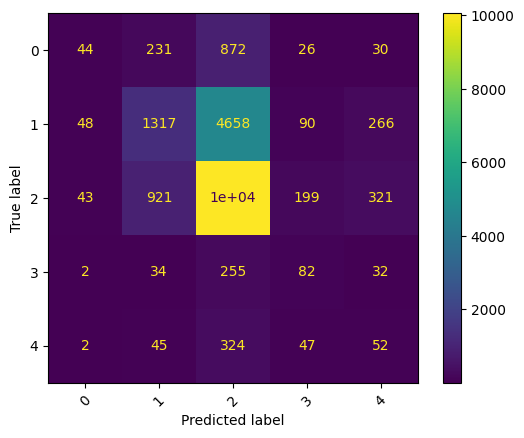

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)

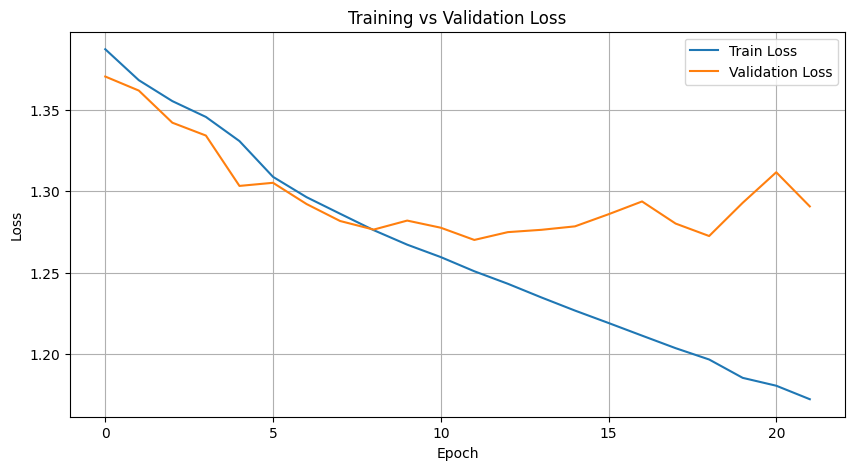

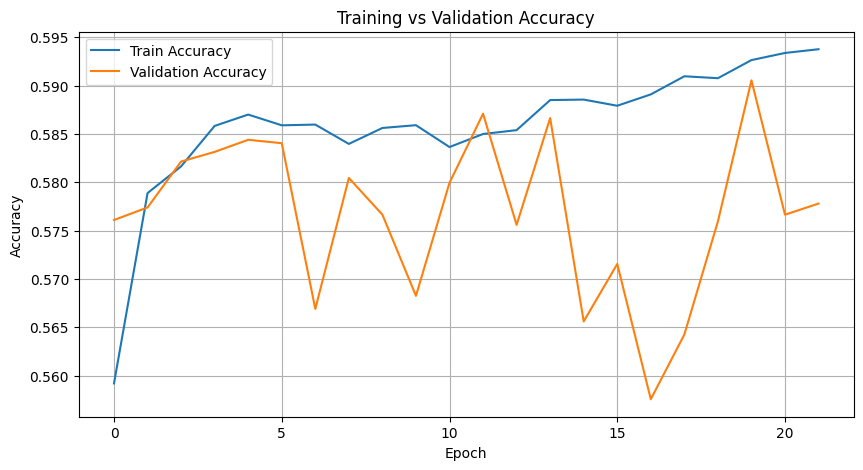

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()